## OBJECTIVE : 
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

# Importing Libraries & getting Data

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5764102551971309974
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 37068302773010922
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect(
    'G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 100000
""", connection)


In [5]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x < 3:
        return 0
    else:
        return 1


score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             100000 non-null  object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 100000 non-null  object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [8]:
filtered_data.shape

(100000, 10)

In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""", connection)

display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display.shape

(80668, 7)

In [11]:
display['COUNT(*)'].sum()

393063

# EDA

## Data Cleaning (Removing Duplicates)

In [12]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""", connection)

display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE : 
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results ,we need to remove the rows having same parameters.

- Steps to do so : 
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others.

In [13]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [14]:
clean_data = sorted_data.drop_duplicates(
    subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)

clean_data.shape

(87775, 10)

# Data Preprocessing

#### Steps : 

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like , or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word 

In [15]:
# sample reviews

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attrac

### 1. Removing URLs

In [16]:
review_1 = re.sub('http\S+', "", review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)

### 2. Removing HTML tags

In [17]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(review_1, 'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2, 'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()

### 3. Removing Apostrophes

In [18]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text


In [19]:
# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)


I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass... but still it did nothing to get them stuck. And then I actually saw a second fly land on it once, and I watched as it flapped it is wings frantically and within 30 secs it had unstuck itself!!!! This product was a total waste of money!


### 4. Removing Numbers / Punctuations /Special Characters

In [20]:
# removing numbers
review_1 = re.sub('\S*\d\S*', "", review_1).strip()
print(review_1)
print('-----------------------------------------')

# removing special characters
review_3 = re.sub('[^A-Za-z0-9]+', ' ', review_3)
print(review_3)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
I had an infestation of fruitflies they were literally everywhere flying around me in my kitchen so I bought this product hoping to at least get rid of a few But after 2 weeks only 1 fly had stuck I was going around with a notepad and squishing the buggers myself with a success rate of 2 3 a day so clearly this product was useless I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass but still it did nothing to get them stuck And then I actually saw a second fly land on it once and I watched as it flapped it is wings frantically and within 30

### 5. Removing Stopwords

In [21]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])


### Combining all Steps

In [22]:
from tqdm import tqdm
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+', "", text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower()
                    for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())


100%|██████████| 87775/87775 [00:19<00:00, 4540.10it/s]


## Splitting into train, test & validation sets

In [23]:
X = preprocessed_reviews
y = np.array(clean_data['Score'])

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)


# Models

In [25]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from scipy.sparse import csr_matrix


## 1. Bag of Words (BoW) 

In [26]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)
X_val_bow = scaler.transform(X_val_bow)

### 1.1 Hyperparameter Tuning

In [27]:
penalties = ['l1', 'l2']
C = [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

parameter_grid = {'penalty': penalties ,'C':C}

In [28]:
lor_model = LogisticRegression(solver='liblinear')
bow_model = HalvingGridSearchCV(lor_model ,parameter_grid ,scoring='roc_auc' ,cv=10 ,verbose=3)

bow_model.fit(X_train_bow ,y_train) 
print('Best Hyperparameters --> ', bow_model.best_params_)
print('Best Accuracy --> ',bow_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4778
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 6/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 7/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 8/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 9/10] END C=0.001, penalty=l1;, sc

### 1.2 Model Building (BoW - LoR)

In [29]:
model_bow = LogisticRegression(penalty=bow_model.best_estimator_.penalty ,C=bow_model.best_estimator_.C ,solver='liblinear')

model_bow.fit(X_train_bow, y_train)

# predicted values for train & test data
y_pred_bow = model_bow.predict_proba(X_train_bow)[:, 1]
y_pred_bow_test = model_bow.predict_proba(X_test_bow)[:, 1]

### 1.3 Model Evaluation (BoW - LoR)

In [30]:
print('Accuracy of BoW model : ',model_bow.score(X_test_bow, y_test))

Accuracy of BoW model :  0.9077203508905176


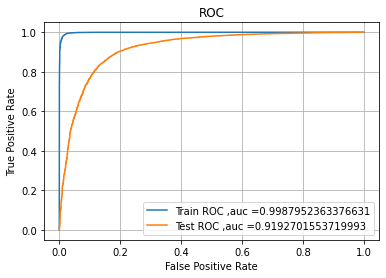

In [31]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_bow)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_bow))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_bow_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


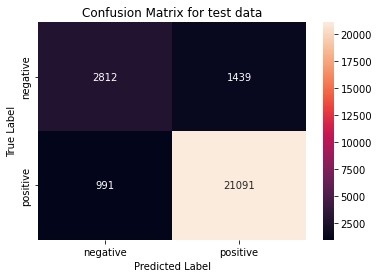

In [32]:
# confusion Matrix for test data
y_pred_bow_test = model_bow.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 1.4 Perturbation Test

In [33]:
lr_bow = LogisticRegression(penalty='l2', C=bow_model.best_estimator_.C)
lr_bow.fit(X_train_bow ,y_train)

LogisticRegression(C=0.1)

In [34]:
# step 1 : Get the weights W after fit your model with the data X
weights_prev = lr_bow.coef_

# step 2 : Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)

X2 = X_train_bow

epsilon = 0.00005
X2.data = X2.data + epsilon 

print(X2.shape)

(43009, 39094)


In [35]:
# step 3 --> Fit the model again on data X' and get the weights W'
model2 = LogisticRegression(penalty='l2', C=bow_model.best_estimator_.C)
model2.fit(X2 ,y_train)

weights_after = model2.coef_

In [36]:
# step 4 --> Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-

epsilon2 = 0.00006 

weights_prev += epsilon2 
weights_after += epsilon2

In [37]:
# step 5 --> find the % change between W and W' (| (W-W') / (W) |)*100)

percent_change = []

for i in range(len(weights_prev[0])):
    diff = weights_after[0][i] - weights_prev[0][i]
    diff /= weights_prev[0][i]
    percent_change.append(diff)

original_percent_change = np.absolute(percent_change)
percent_change = sorted(np.absolute(percent_change))[::-1]

# diff = abs((weights_prev - weights_after) / (weights_prev))
# percent_change = diff*100 

percent_change[:10]

[2392.3130091236794,
 340.73263949886007,
 194.70508489510883,
 164.7875770470217,
 158.52360129904133,
 148.62852181534032,
 148.62852181534032,
 148.62852181534032,
 148.62852181534032,
 148.62852181534032]

In [38]:
# calculating percentiles from 0 to 100 

for i in range(10,101 ,10):
    print('{}th percentile value : {}'.format(i ,np.percentile(percent_change ,i))) 

10th percentile value : 0.006897179909938107
20th percentile value : 0.016119981075157573
30th percentile value : 0.02977913076534674
40th percentile value : 0.05219918428749633
50th percentile value : 0.09822950203598164
60th percentile value : 0.24680191965477052
70th percentile value : 0.4785252870221824
80th percentile value : 0.5721716090285607
90th percentile value : 0.6529588333425332
100th percentile value : 2392.3130091236794


In [39]:
# there is a abrupt change when going from 90th percentile to 100th percentile. 

for i in range(91,101 ,1):
    print('{}th percentile value : {}'.format(i ,np.percentile(percent_change ,i)))

91th percentile value : 0.6673830677305774
92th percentile value : 0.6817415432038573
93th percentile value : 0.690734211165577
94th percentile value : 0.7870249611405244
95th percentile value : 1.2459078423202692
96th percentile value : 1.5856917335451022
97th percentile value : 1.695540991214433
98th percentile value : 2.1878202794590953
99th percentile value : 3.8136703955406626
100th percentile value : 2392.3130091236794


In [40]:
# looking more closely 

for i in range(1,11,1):
    print('{}th percentile value : {}'.format(i * 1.0/10 + 99 ,np.percentile(percent_change ,i*1.0/10 +99)))

99.1th percentile value : 4.1193686020744895
99.2th percentile value : 4.970894240876275
99.3th percentile value : 5.845307584036691
99.4th percentile value : 6.482307431583365
99.5th percentile value : 7.222078375305392
99.6th percentile value : 8.201893892273239
99.7th percentile value : 10.02180374951895
99.8th percentile value : 16.557391538164453
99.9th percentile value : 38.56641527957147
100.0th percentile value : 2392.3130091236794


In [41]:
# getting percentage change dataframe

percent_change_df = pd.DataFrame(percent_change ,index=vectorizer.get_feature_names_out() ,columns=['Percent_Change'])

percent_change_df.head()

,Percent_Change
aa,2392.313009
aaa,340.732639
aaaa,194.705085
aaaaaaarrrrrggghhh,164.787577
aaaaah,158.523601


In [42]:
# Printing the feature names whose percent-change is more than a threshold x

percent_change_df = percent_change_df[percent_change_df['Percent_Change']
                                      > 38.56641527957147]
percent_change_df.shape

(40, 1)

In [43]:
percent_change_df.sort_values(by='Percent_Change' ,inplace=True)

percent_change_df.head(10)

,Percent_Change
ablaze,38.818159
abit,39.059222
ability,41.601261
abilities,44.769028
abiding,45.877332
abide,46.683041
abeneficial,51.466098
abe,51.466098
abdominal,51.466098
abdomen,51.466098


### 1.5 Calculating sparsity on weight vector (after L1 regularization)

In [44]:
# count --> Counts number of non zero weights for a given C 
# error --> stores error for each value of c
count =[]
error =[]

c_sparse = np.array([10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2])

for i in c_sparse:
    model = LogisticRegression(penalty='l1', C=i ,solver='liblinear')
    model.fit(X_train_bow ,y_train)
    
    count.append(np.count_nonzero(model.coef_))
    error.append(1 - model.score(X_test_bow ,y_test))
    print('For C: {}    Number of non-zero coefficients : {}'.format(i ,np.count_nonzero(model.coef_)))

For C: 0.001    Number of non-zero coefficients : 34
For C: 0.01    Number of non-zero coefficients : 2818
For C: 0.1    Number of non-zero coefficients : 8523
For C: 1.0    Number of non-zero coefficients : 9890
For C: 10.0    Number of non-zero coefficients : 10604
For C: 100.0    Number of non-zero coefficients : 13989


In [45]:
weights = model_bow.coef_ 
print('Number of non-zero element in weight vector : {}'.format(np.count_nonzero(weights)))

Number of non-zero element in weight vector : 8557


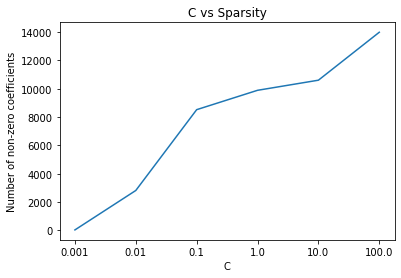

In [46]:
# plotting c vs Sparsity

plt.title('C vs Sparsity')
plt.plot(range(len(c_sparse)), count)

plt.xlabel('C')
plt.ylabel('Number of non-zero coefficients')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()


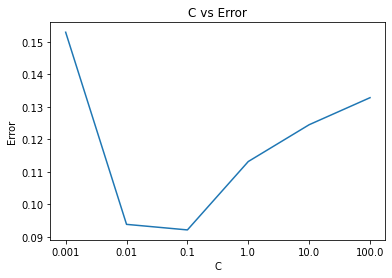

In [47]:
# plotting c vs error

plt.title('C vs Error')
plt.plot(range(len(c_sparse)), error)

plt.xlabel('C')
plt.ylabel('Error')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()


### 1.6 Feature Importance

In [48]:
features = vectorizer.get_feature_names_out()
coefs = model_bow.coef_.reshape(-1,1)

dataframe = pd.DataFrame(coefs ,columns=['Coefficient'] ,index=features)
top_positive = dataframe.sort_values(by='Coefficient' ,ascending=False).head(10)
top_negative = dataframe.sort_values(by='Coefficient' ,ascending=True).head(10)

print('Top 10 positive features --> ')
print(top_positive)
print('----------------------------------------')
print('Top 10 negative features --> ')
print(top_negative)


Top 10 positive features --> 
           Coefficient
great         1.022546
best          0.730144
delicious     0.729398
good          0.717871
perfect       0.660328
love          0.545726
nice          0.495011
loves         0.493060
excellent     0.457029
wonderful     0.419859
----------------------------------------
Top 10 negative features --> 
               Coefficient
not              -1.202898
disappointed     -0.352664
worst            -0.339348
terrible         -0.336152
awful            -0.322912
unfortunately    -0.315163
horrible         -0.293648
taste            -0.280719
money            -0.273594
bland            -0.253625


## 2. TFIDF

In [49]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

scaler = StandardScaler(with_mean=False)

X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)
X_val_tfidf = scaler.transform(X_val_tfidf)


### 2.1 Hyperparameter Tuning

In [50]:
penalties = ['l1', 'l2']
C = [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

parameter_grid = {'penalty': penalties, 'C': C}

In [51]:
lor_model = LogisticRegression(solver='liblinear')
tfidf_model = HalvingGridSearchCV(lor_model, parameter_grid, scoring='roc_auc', cv=10, verbose=3)

tfidf_model.fit(X_train_tfidf, y_train)
print('Best Hyperparameters --> ', tfidf_model.best_params_)
print('Best Accuracy --> ', tfidf_model.best_score_)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4778
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 6/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 7/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 8/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 9/10] END C=0.001, penalty=l1;, sc

### 2.2 Model Building (TFIDF)

In [52]:
model_tfidf = LogisticRegression(penalty=tfidf_model.best_estimator_.penalty, C=tfidf_model.best_estimator_.C, solver='liblinear')

model_tfidf.fit(X_train_tfidf, y_train)

# predicted values for train & test data
y_pred_tfidf = model_tfidf.predict_proba(X_train_tfidf)[:, 1]
y_pred_tfidf_test = model_tfidf.predict_proba(X_test_tfidf)[:, 1]

### 2.3 Model Evaluation (TFIDF)

In [53]:
print('Accuracy of tfidf model : ', model_tfidf.score(X_test_tfidf, y_test))

Accuracy of tfidf model :  0.9107583640299244


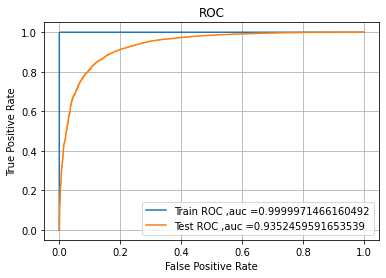

In [54]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_tfidf)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1,
        label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_tfidf))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_tfidf_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

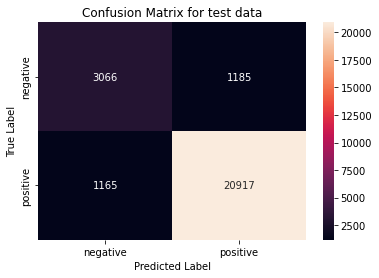

In [55]:
# confusion Matrix for test data
y_pred_tfidf_test = model_tfidf.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2.4 Perturbation Test

In [56]:
lr_tfidf = LogisticRegression(penalty='l2', C=tfidf_model.best_estimator_.C)
lr_tfidf.fit(X_train_tfidf ,y_train)

LogisticRegression(C=10)

In [57]:
# step 1 : Get the weights W after fit your model with the data X
weights_prev = lr_tfidf.coef_

# step 2 : Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)

X2 = X_train_tfidf

epsilon = 0.00005
X2.data = X2.data + epsilon 

print(X2.shape)

(43009, 25697)


In [58]:
# step 3 --> Fit the model again on data X' and get the weights W'
model2 = LogisticRegression(penalty='l2', C=tfidf_model.best_estimator_.C)
model2.fit(X2 ,y_train)

weights_after = model2.coef_

In [59]:
# step 4 --> Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-

epsilon2 = 0.00006 

weights_prev += epsilon2 
weights_after += epsilon2

In [60]:
# step 5 --> find the % change between W and W' (| (W-W') / (W) |)*100)

percent_change = []

for i in range(len(weights_prev[0])):
    diff = weights_after[0][i] - weights_prev[0][i]
    diff /= weights_prev[0][i]
    percent_change.append(diff)

original_percent_change = np.absolute(percent_change)
percent_change = sorted(np.absolute(percent_change))[::-1]

# diff = abs((weights_prev - weights_after) / (weights_prev))
# percent_change = diff*100 

percent_change[:10]

[918.8622423636559,
 911.1329734170984,
 673.8969572931771,
 261.8213991721799,
 252.7790971618981,
 228.62438714732892,
 224.11368974633453,
 215.0865740685301,
 98.35208137533631,
 86.47894582960829]

In [61]:
# calculating percentiles from 0 to 100

for i in range(10, 101, 10):
    print('{}th percentile value : {}'.format(i, np.percentile(percent_change, i)))

10th percentile value : 0.008623639305121564
20th percentile value : 0.017574262628826984
30th percentile value : 0.027487339054233534
40th percentile value : 0.03879544628029588
50th percentile value : 0.052595747413588974
60th percentile value : 0.07117193853103258
70th percentile value : 0.10099015112779758
80th percentile value : 0.1416832899349934
90th percentile value : 0.2904111623900614
100th percentile value : 918.8622423636559


In [62]:
# there is a abrupt change when going from 90th percentile to 100th percentile.

for i in range(91, 101, 1):
    print('{}th percentile value : {}'.format(i, np.percentile(percent_change, i)))

91th percentile value : 0.3223560869341376
92th percentile value : 0.36463294769829746
93th percentile value : 0.4201160607713694
94th percentile value : 0.4956486325415003
95th percentile value : 0.59772192450199
96th percentile value : 0.7506425627025278
97th percentile value : 1.006738476990695
98th percentile value : 1.4789136934975045
99th percentile value : 2.8261554832349725
100th percentile value : 918.8622423636559


In [63]:
# looking more closely

for i in range(1, 11, 1):
    print('{}th percentile value : {}'.format(i * 1.0/10 + 99, np.percentile(percent_change, i*1.0/10 + 99)))

99.1th percentile value : 3.101612109428851
99.2th percentile value : 3.5329332592206124
99.3th percentile value : 4.15859207515522
99.4th percentile value : 4.963023747047346
99.5th percentile value : 5.781537822138468
99.6th percentile value : 7.190503695035301
99.7th percentile value : 9.725609074201081
99.8th percentile value : 15.100832786216607
99.9th percentile value : 30.608198000303794
100.0th percentile value : 918.8622423636559


In [64]:
# getting percentage change dataframe

percent_change_df = pd.DataFrame(percent_change, index=tfidf.get_feature_names_out(), columns=['Percent_Change'])

percent_change_df.head()

,Percent_Change
aa,918.862242
aafco,911.132973
abdominal,673.896957
ability,261.821399
able,252.779097


In [65]:
# Printing the feature names whose percent-change is more than a threshold x

percent_change_df = percent_change_df[percent_change_df['Percent_Change']
                                      > 30.608198000303794]
percent_change_df.shape

(26, 1)

In [66]:
percent_change_df.sort_values(by='Percent_Change', inplace=True)

percent_change_df.head(10)

,Percent_Change
absolute best,30.672832
absolute,33.497547
absent,35.899658
absence,36.087361
able use,36.704662
able try,37.244523
able tell,37.384925
able taste,41.403174
able purchase,42.501272
able order,42.685513


### 2.5 Calculating sparsity on weight vector (after L1 regularization)

In [67]:
# count --> Counts number of non zero weights for a given C
# error --> stores error for each value of c
count = []
error = []

c_sparse = np.array([10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2])

for i in c_sparse:
    model = LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_tfidf, y_train)

    count.append(np.count_nonzero(model.coef_))
    error.append(1 - model.score(X_test_tfidf, y_test))
    print('For C: {}    Number of non-zero coefficients : {}'.format(i,np.count_nonzero(model.coef_)))

For C: 0.001    Number of non-zero coefficients : 42
For C: 0.01    Number of non-zero coefficients : 2017
For C: 0.1    Number of non-zero coefficients : 8184
For C: 1.0    Number of non-zero coefficients : 9684
For C: 10.0    Number of non-zero coefficients : 11862
For C: 100.0    Number of non-zero coefficients : 20687


In [68]:
weights = model_tfidf.coef_
print('Number of non-zero element in weight vector : {}'.format(np.count_nonzero(weights)))

Number of non-zero element in weight vector : 11893


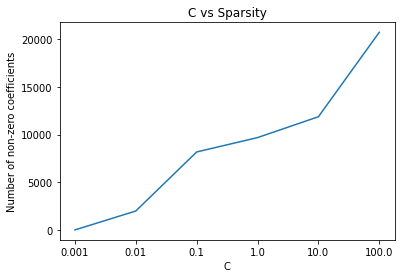

In [69]:
# plotting c vs Sparsity

plt.title('C vs Sparsity')
plt.plot(range(len(c_sparse)), count)

plt.xlabel('C')
plt.ylabel('Number of non-zero coefficients')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()


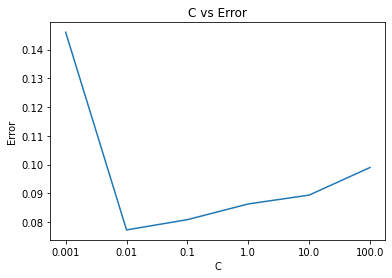

In [70]:
# plotting c vs error

plt.title('C vs Error')
plt.plot(range(len(c_sparse)), error)

plt.xlabel('C')
plt.ylabel('Error')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()

### 2.6 Feature Importance (TFIDF)

In [71]:
features = tfidf.get_feature_names_out()
coefs = model_tfidf.coef_.reshape(-1, 1)

dataframe = pd.DataFrame(coefs, columns=['Coefficient'], index=features)
top_positive = dataframe.sort_values(
    by='Coefficient', ascending=False).head(10)
top_negative = dataframe.sort_values(by='Coefficient', ascending=True).head(10)

print('Top 10 positive features --> ')
print(top_positive)
print('----------------------------------------')
print('Top 10 negative features --> ')
print(top_negative)


Top 10 positive features --> 
                  Coefficient
great                1.943085
delicious            1.347909
best                 1.345880
good                 1.272864
love                 1.191686
perfect              1.057989
loves                0.987419
highly recommend     0.897251
not disappointed     0.883666
wonderful            0.794768
----------------------------------------
Top 10 negative features --> 
               Coefficient
disappointed     -0.797379
worst            -0.745576
terrible         -0.601240
not good         -0.554785
disappointing    -0.548520
awful            -0.537716
not worth        -0.528181
horrible         -0.522720
two stars        -0.512104
not buy          -0.463136


## 3. AVG - W2V

In [72]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))


100%|██████████| 43009/43009 [00:31<00:00, 1354.68it/s]

43009
50


In [73]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []
sent_vectors_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_val.append(sent_vectors)

print(len(sent_vectors_val))
print(len(sent_vectors_val[0]))


100%|██████████| 18433/18433 [00:13<00:00, 1318.04it/s]

18433
50


In [74]:
#word2vec for test data

sent_list_test = []
sent_vectors_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

for sent in tqdm(sent_list_test):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_test.append(sent_vectors)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 26333/26333 [00:20<00:00, 1308.73it/s]

26333
50


In [75]:
X_train_avg_w2v = sent_vectors_train
X_val_avg_w2v = sent_vectors_val
X_test_avg_w2v = sent_vectors_test

### 3.1 Hyperparameter Tuning 

In [76]:
penalties = ['l1', 'l2']
C = [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

parameter_grid = {'penalty': penalties ,'C':C}

In [77]:
lor_model = LogisticRegression(solver='liblinear')
avg_w2v_model = HalvingGridSearchCV(lor_model ,parameter_grid ,scoring='roc_auc' ,cv=10 ,verbose=3)

avg_w2v_model.fit(X_train_avg_w2v ,y_train) 
print('Best Hyperparameters --> ', avg_w2v_model.best_params_)
print('Best Accuracy --> ',avg_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4778
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 6/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 7/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 8/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 9/10] END C=0.001, penalty=l1;, sc

### 3.2 Model Building (avg_w2v)


In [78]:
model_avg_w2v = LogisticRegression(penalty=avg_w2v_model.best_estimator_.penalty ,C=avg_w2v_model.best_estimator_.C ,solver='liblinear')

model_avg_w2v.fit(X_train_avg_w2v, y_train)

# predicted values for train & test data
y_pred_avg_w2v = model_avg_w2v.predict_proba(X_train_avg_w2v)[:, 1]
y_pred_avg_w2v_test = model_avg_w2v.predict_proba(X_test_avg_w2v)[:, 1]

### 1.3 Model Evaluation (avg_w2v)

In [79]:
print('Accuracy of avg_w2v model : ',model_avg_w2v.score(X_test_avg_w2v, y_test))

Accuracy of avg_w2v model :  0.8849732275092089


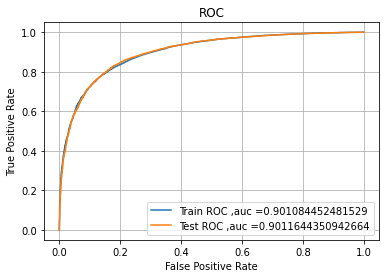

In [80]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_avg_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_avg_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_avg_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_avg_w2v_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


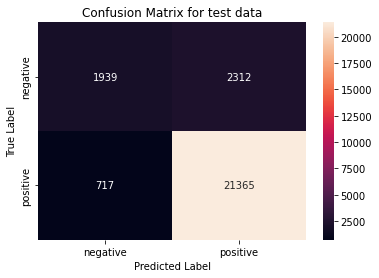

In [81]:
# confusion Matrix for test data
y_pred_avg_w2v_test = model_avg_w2v.predict(X_test_avg_w2v)

confusion = confusion_matrix(y_test, y_pred_avg_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 3.4 Calculating sparsity on weight vector (after L1 regularization)


In [82]:
# count --> Counts number of non zero weights for a given C 
# error --> stores error for each value of c
count =[]
error =[]

c_sparse = np.array([10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2])

for i in c_sparse:
    model = LogisticRegression(penalty='l1', C=i ,solver='liblinear')
    model.fit(X_train_avg_w2v ,y_train)
    
    count.append(np.count_nonzero(model.coef_))
    error.append(1 - model.score(X_test_avg_w2v ,y_test))
    print('For C: {}    Number of non-zero coefficients : {}'.format(i ,np.count_nonzero(model.coef_)))

For C: 0.001    Number of non-zero coefficients : 5
For C: 0.01    Number of non-zero coefficients : 26
For C: 0.1    Number of non-zero coefficients : 49
For C: 1.0    Number of non-zero coefficients : 50
For C: 10.0    Number of non-zero coefficients : 50
For C: 100.0    Number of non-zero coefficients : 50


In [83]:
weights = model_avg_w2v.coef_ 
print('Number of non-zero element in weight vector : {}'.format(np.count_nonzero(weights)))

Number of non-zero element in weight vector : 50


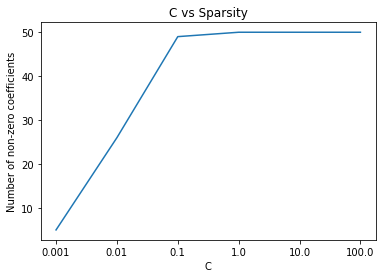

In [84]:
# plotting c vs Sparsity

plt.title('C vs Sparsity')
plt.plot(range(len(c_sparse)), count)

plt.xlabel('C')
plt.ylabel('Number of non-zero coefficients')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()

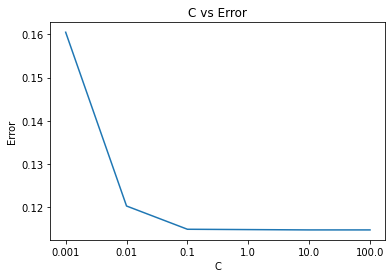

In [85]:
# plotting c vs error

plt.title('C vs Error')
plt.plot(range(len(c_sparse)), error)

plt.xlabel('C')
plt.ylabel('Error')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()

## 4. TFIDF-W2V

In [86]:
sent_list_train = []

for sentence in X_train:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(
    ngram_range=(1, 2), min_df=10, max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X_train)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(
    zip(tfidf_vectors.get_feature_names(), list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0

    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf)
            weight_sum += tfidf

    if weight_sum != 0:
        sent_vectors /= weight_sum

    tfidf_sent_vectors_train.append(sent_vectors)
    row += 1


100%|██████████| 43009/43009 [00:38<00:00, 1110.03it/s]


In [87]:
#word2vec for validation data (using same w2v model and words)

sent_list_val = []

for sentence in X_val:
    sent_list_val.append(sentence.split())

tfidf_sent_vectors_val = []
row = 0

for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:16<00:00, 1100.29it/s]


In [88]:
#word2vec for test data

sent_list_test = []

for sentence in X_test:
    sent_list_test.append(sentence.split())

tfidf_sent_vectors_test = []
row=0
    
for sent in tqdm(sent_list_val):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_val.append(sent_vectors)
    row +=1

100%|██████████| 18433/18433 [00:16<00:00, 1096.63it/s]


In [89]:
X_train_tfidf_w2v = sent_vectors_train
X_val_tfidf_w2v = sent_vectors_val
X_test_tfidf_w2v = sent_vectors_test

### 4.1 Hyperparameter Tuning 

In [90]:
penalties = ['l1', 'l2']
C = [10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]

parameter_grid = {'penalty': penalties, 'C': C}

In [91]:
lor_model = LogisticRegression(solver='liblinear')
tfidf_w2v_model = HalvingGridSearchCV(lor_model ,parameter_grid ,scoring='roc_auc' ,cv=10 ,verbose=3)

tfidf_w2v_model.fit(X_train_tfidf_w2v ,y_train) 
print('Best Hyperparameters --> ', tfidf_w2v_model.best_params_)
print('Best Accuracy --> ',tfidf_w2v_model.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4778
max_resources_: 43009
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4778
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 6/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 7/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 8/10] END C=0.001, penalty=l1;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 9/10] END C=0.001, penalty=l1;, sc

### 4.2 Model Building (tfidf_w2v)

In [92]:
model_tfidf_w2v = LogisticRegression(
    penalty=tfidf_w2v_model.best_estimator_.penalty, C=tfidf_w2v_model.best_estimator_.C, solver='liblinear')

model_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)

# predicted values for train & test data
y_pred_tfidf_w2v = model_tfidf_w2v.predict_proba(X_train_tfidf_w2v)[:, 1]
y_pred_tfidf_w2v_test = model_tfidf_w2v.predict_proba(X_test_tfidf_w2v)[:, 1]


### 4.3 Model Evaluation (tfidf_w2v)

In [93]:
print('Accuracy of tfidf_w2v model : ',model_tfidf_w2v.score(X_test_tfidf_w2v, y_test))

Accuracy of tfidf_w2v model :  0.8852010784946645


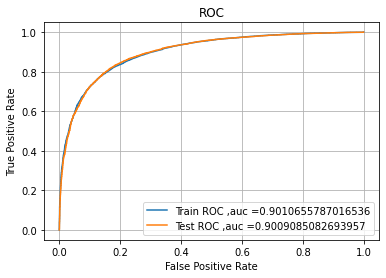

In [94]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_train, y_pred_tfidf_w2v)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(
    y_test, y_pred_tfidf_w2v_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(
    str(roc_auc_score(y_train, y_pred_tfidf_w2v))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(
    str(roc_auc_score(y_test, y_pred_tfidf_w2v_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()

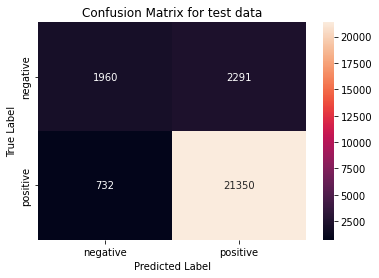

In [95]:
# confusion Matrix for test data
y_pred_tfidf_w2v_test = model_tfidf_w2v.predict(X_test_tfidf_w2v)

confusion = confusion_matrix(y_test, y_pred_tfidf_w2v_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 4.4 Calculating sparsity on weight vector (after L1 regularization)

In [96]:
# count --> Counts number of non zero weights for a given C
# error --> stores error for each value of c
count = []
error = []

c_sparse = np.array([10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2])

for i in c_sparse:
    model = LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_tfidf_w2v, y_train)

    count.append(np.count_nonzero(model.coef_))
    error.append(1 - model.score(X_test_tfidf_w2v, y_test))
    print('For C: {}    Number of non-zero coefficients : {}'.format(i,
          np.count_nonzero(model.coef_)))


For C: 0.001    Number of non-zero coefficients : 5
For C: 0.01    Number of non-zero coefficients : 26
For C: 0.1    Number of non-zero coefficients : 49
For C: 1.0    Number of non-zero coefficients : 50
For C: 10.0    Number of non-zero coefficients : 50
For C: 100.0    Number of non-zero coefficients : 50


In [97]:
weights = model_tfidf_w2v.coef_
print('Number of non-zero element in weight vector : {}'.format(np.count_nonzero(weights)))


Number of non-zero element in weight vector : 50


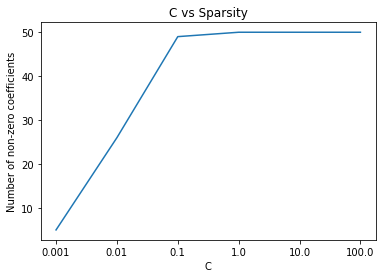

In [98]:
# plotting c vs Sparsity

plt.title('C vs Sparsity')
plt.plot(range(len(c_sparse)), count)

plt.xlabel('C')
plt.ylabel('Number of non-zero coefficients')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()

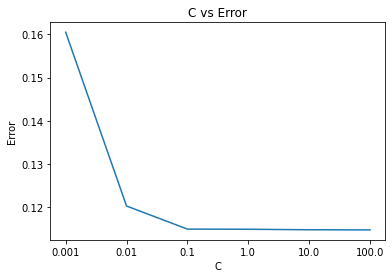

In [99]:
# plotting c vs error

plt.title('C vs Error')
plt.plot(range(len(c_sparse)), error)

plt.xlabel('C')
plt.ylabel('Error')
plt.xticks(range(len(c_sparse)), c_sparse)
plt.show()


# Model Comparision

### Creating a prettytable to see which model performed better

In [4]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Vectorizer', 'Best Hyperparameters', 'AUC']
x.add_row(['BOW', {'C': 0.1, 'penalty': 'l1'}, 0.91927])
x.add_row(['TFIDF', {'C': 10, 'penalty': 'l1'}, 0.93524])
x.add_row(['AVG-W2V', {'C': 0.1, 'penalty': 'l2'}, 0.90116])
x.add_row(['TFIDF-W2V', {'C': 1, 'penalty': 'l2'}, 0.90090])

x.sortby = 'AUC'
x.reversesort = True
print(x)


+------------+-----------------------------+---------+
| Vectorizer |     Best Hyperparameters    |   AUC   |
+------------+-----------------------------+---------+
|   TFIDF    |  {'C': 10, 'penalty': 'l1'} | 0.93524 |
|    BOW     | {'C': 0.1, 'penalty': 'l1'} | 0.91927 |
|  AVG-W2V   | {'C': 0.1, 'penalty': 'l2'} | 0.90116 |
| TFIDF-W2V  |  {'C': 1, 'penalty': 'l2'}  |  0.9009 |
+------------+-----------------------------+---------+
